# **Project Name**    -    Multiclass Fish Image Classification

##### **Project Type**    - Classification
##### **Contribution**    - Individual

# **Project Summary -**

# **GitHub Link -**

# **Problem Statement**

This project focuses on classifying fish images into multiple categories using deep learning models. The task involves training a CNN from scratch and leveraging transfer learning with pre-trained models to enhance performance. The project also includes saving models for later use and deploying a Streamlit application to predict fish categories from user-uploaded images.

# **Buisness Use Cases**

1. Enhanced Accuracy: Determine the best model architecture for fish image classification.
2. Deployment Ready: Create a user-friendly web application for real-time predictions.
3. Model Comparison: Evaluate and compare metrics across models to select the most suitable approach for the task.

# ***Let's Begin !***

In [1]:
# Project: FishVision AI - Multiclass Fish Image Classification
# Author: [Om Jaiswal]
# Description: This notebook builds and evaluates multiple deep learning models to classify fish species based on image data.

# ================================
# 🔧 Importing Required Libraries
# ================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
import warnings
import shutil
warnings.filterwarnings("ignore")
import os
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import pickle

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.10.0


## Data Preprocessing and Augmentation

In [3]:
# The target size of each input image (height, width)
# Most pre-trained models like VGG16, ResNet expect 224x224
IMAGE_SIZE = (224, 224)

# Number of images to process in one batch during training or evaluation
BATCH_SIZE = 32

# Paths to training, validation, and test image folders
TRAIN_DIR = "data/train/"
VAL_DIR   = "data/val/"
TEST_DIR  = "data/test/"

In [4]:
# -----------------------------------------------
# ⚙️ Data Augmentation for Training Generator
# -----------------------------------------------

# This generator applies image augmentation and rescales pixel values
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1] range
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    zoom_range=0.2,             # Randomly zoom in on images (up to 20%)
    width_shift_range=0.1,      # Randomly shift images horizontally (10% of width)
    height_shift_range=0.1,     # Randomly shift images vertically (10% of height)
    horizontal_flip=True        # Randomly flip images horizontally
)

In [5]:
# -----------------------------------------------
# 🔄 Data Generator for Validation and Test
# -----------------------------------------------

# No augmentation here, only rescaling for consistency
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# -----------------------------------------------
# 📦 Load Image Batches from Train Folder
# -----------------------------------------------

train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,            # Path to training images
    target_size=IMAGE_SIZE,         # Resize all images to 224x224
    batch_size=BATCH_SIZE,          # Load images in batches of 32
    class_mode='categorical',       # Use categorical labels for multi-class classification
    shuffle=True,                   # Shuffle images each epoch to improve learning
    seed=42                         # Ensure reproducibility of shuffling
)

Found 6225 images belonging to 11 classes.


In [7]:
# -----------------------------------------------
# 📦 Load Image Batches from Validation Folder
# -----------------------------------------------

val_generator = val_datagen.flow_from_directory(
    directory=VAL_DIR,              # Path to validation images
    target_size=IMAGE_SIZE,         # Resize to same dimensions as training
    batch_size=BATCH_SIZE,          # Batch size same as training
    class_mode='categorical',       # Ensure one-hot encoded labels
    shuffle=False                   # DO NOT shuffle for validation — keeps predictions consistent
)

Found 1092 images belonging to 11 classes.


In [8]:
# -----------------------------------------------
# 📦 Load Image Batches from Test Folder
# -----------------------------------------------

test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,             # Path to test images
    target_size=IMAGE_SIZE,         # Resize test images
    batch_size=BATCH_SIZE,          # Same batch size
    class_mode='categorical',       # Same label format
    shuffle=False                   # Do not shuffle — important for evaluation/prediction
)

Found 3187 images belonging to 11 classes.


In [9]:
# Count images per class in the training folder
def count_images_in_each_class(folder_path):
    """
    Counts number of images in each class folder.
    """
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len([
                f for f in os.listdir(class_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = count
    return pd.Series(class_counts).sort_values(ascending=False)

# Count images in training set
class_counts = count_images_in_each_class(TRAIN_DIR)
class_counts

animal fish                         1096
fish sea_food trout                  580
fish sea_food red_mullet             579
fish sea_food shrimp                 576
fish sea_food hourse_mackerel        573
fish sea_food red_sea_bream          571
fish sea_food black_sea_sprat        569
fish sea_food gilt_head_bream        566
fish sea_food striped_red_mullet     547
fish sea_food sea_bass               538
animal fish bass                      30
dtype: int64

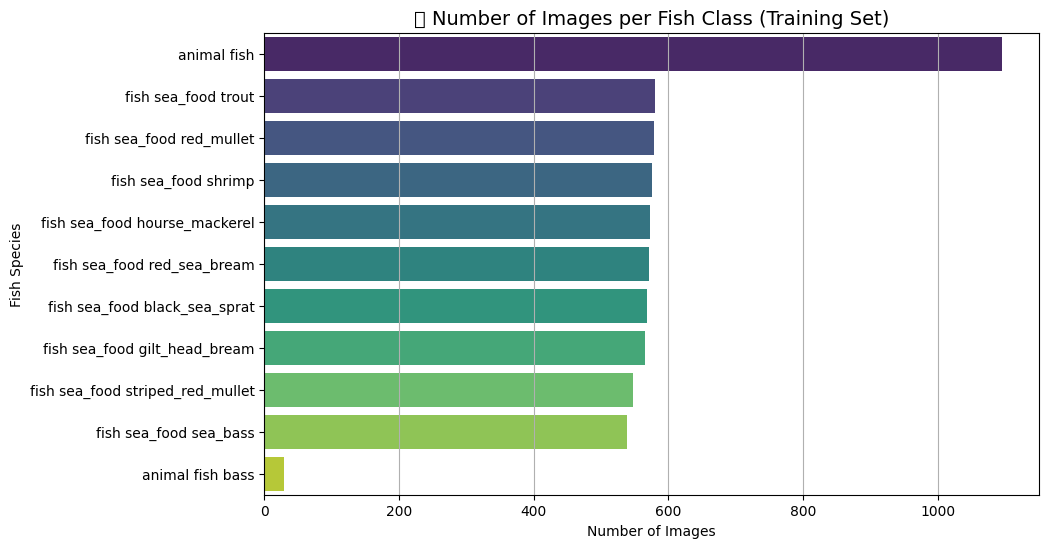

In [27]:
# Plot image count per class
plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis')
plt.title("📊 Number of Images per Fish Class (Training Set)", fontsize=14)
plt.xlabel("Number of Images")
plt.ylabel("Fish Species")
plt.grid(axis='x')
plt.show()

### 📊 Chart 1: Image Count per Fish Class (Training Set)

**Why did you pick this specific chart?**  
This bar chart helps us perform **univariate analysis** on the target classes. It gives a clear overview of how many training images are available per fish species and highlights **class imbalance**.

---

**What insight(s) were found from the chart?**  
- "animal fish" has the highest number of images (1096).
- Most other classes range from ~530 to ~580 images.
- The class "animal fish bass" has **only 30 images**, which is a serious imbalance.

---

**Will the gained insights help create a positive business impact?**  
✅ Yes. These insights guide key preprocessing decisions:
- Apply **data augmentation** to "animal fish bass" and any underrepresented classes.
- Use **class weighting** during training to reduce model bias.
- Helps ensure the model performs equally across all fish types — critical if the classifier is used in **commercial fishing, supply chain automation, or ecological studies.**

---

**Are there any insights that could lead to negative growth?**  
⚠️ Yes.
- The extreme imbalance in "animal


In [10]:
# Get class indices and corresponding labels
labels = train_generator.classes  # array of numeric labels
class_names = list(train_generator.class_indices.keys())

# Compute class weights (higher weight for underrepresented class)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
# Convert to dict format for model.fit()
class_weight_dict = dict(enumerate(class_weights))

print("Computed Class Weights:")
for i, w in class_weight_dict.items():
    print(f"{class_names[i]}: {w:.2f}")

Computed Class Weights:
animal fish: 0.52
animal fish bass: 18.86
fish sea_food black_sea_sprat: 0.99
fish sea_food gilt_head_bream: 1.00
fish sea_food hourse_mackerel: 0.99
fish sea_food red_mullet: 0.98
fish sea_food red_sea_bream: 0.99
fish sea_food sea_bass: 1.05
fish sea_food shrimp: 0.98
fish sea_food striped_red_mullet: 1.03
fish sea_food trout: 0.98


## Model Training

### Custom CNN model

In [17]:
def build_cnn_model(input_shape, num_classes):
    """
    Builds a custom CNN model.
    
    Parameters:
        input_shape (tuple): Shape of input images (height, width, channels)
        num_classes (int): Number of output classes for classification

    Returns:
        model (tf.keras.Model): Compiled CNN model
    """
    model = Sequential()

    # Convolution Block 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Convolution Block 2
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Convolution Block 3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Flatten & Dense Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Regularization
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multiclass

    # Compile Model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [18]:
# Define Callbacks (EarlyStopping & Save Best Model)

# Save the best model based on validation accuracy
checkpoint_path = 'models/cnn_best_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

# Stop training if validation loss doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)


In [19]:
# Get class indices and corresponding labels
labels = train_generator.classes  # array of numeric labels
class_names = list(train_generator.class_indices.keys())

# Compute class weights (higher weight for underrepresented class)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
# Convert to dict format for model.fit()
class_weight_dict = dict(enumerate(class_weights))

print("Computed Class Weights:")
for i, w in class_weight_dict.items():
    print(f"{class_names[i]}: {w:.2f}")

Computed Class Weights:
animal fish: 0.52
animal fish bass: 18.86
fish sea_food black_sea_sprat: 0.99
fish sea_food gilt_head_bream: 1.00
fish sea_food hourse_mackerel: 0.99
fish sea_food red_mullet: 0.98
fish sea_food red_sea_bream: 0.99
fish sea_food sea_bass: 1.05
fish sea_food shrimp: 0.98
fish sea_food striped_red_mullet: 1.03
fish sea_food trout: 0.98


In [22]:
#  Train the CNN Model
# Input shape (height, width, channels)
input_shape = (224, 224, 3)

# Number of classes from generator
num_classes = train_generator.num_classes

# Build model
cnn_model = build_cnn_model(input_shape, num_classes)

# Train model
try:
    cnn_history = cnn_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        class_weight=class_weight_dict,
        epochs=30,
        callbacks=[early_stop, checkpoint]
    )
except Exception as e:
    print(f"❌ Training failed due to: {e}")


Epoch 1/30
194/194 [==============================] - ETA: 0s - loss: 2.7570 - accuracy: 0.3317
Epoch 1: val_accuracy improved from -inf to 0.10754, saving model to models\cnn_best_model.h5
194/194 [==============================] - 141s 712ms/step - loss: 2.7570 - accuracy: 0.3317 - val_loss: 9.6547 - val_accuracy: 0.1075
Epoch 2/30
194/194 [==============================] - ETA: 0s - loss: 2.1157 - accuracy: 0.4324
Epoch 2: val_accuracy improved from 0.10754 to 0.23346, saving model to models\cnn_best_model.h5
194/194 [==============================] - 63s 324ms/step - loss: 2.1157 - accuracy: 0.4324 - val_loss: 3.7856 - val_accuracy: 0.2335
Epoch 3/30
194/194 [==============================] - ETA: 0s - loss: 1.7834 - accuracy: 0.4576
Epoch 3: val_accuracy improved from 0.23346 to 0.50551, saving model to models\cnn_best_model.h5
194/194 [==============================] - 50s 258ms/step - loss: 1.7834 - accuracy: 0.4576 - val_loss: 1.3544 - val_accuracy: 0.5055
Epoch 4/30
194/194 [=

In [23]:
# Save training history
with open('models/cnn_training_history.pkl', 'wb') as f:
    pickle.dump(cnn_history.history, f)

In [24]:
print("Best Validation Accuracy Achieved:", max(cnn_history.history['val_accuracy']))

Best Validation Accuracy Achieved: 0.9016544222831726


In [26]:
final_epoch = len(cnn_history.history['accuracy']) - 1
print(f"Final training accuracy: {cnn_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final validation accuracy: {cnn_history.history['val_accuracy'][final_epoch]:.4f}")

Final training accuracy: 0.7425
Final validation accuracy: 0.8189


### Transfer learning model using VGG 16

In [23]:
# ----------------------------------------------
# Load the VGG16 base model (excluding top layers)
# ----------------------------------------------
vgg_base = VGG16(
    weights='imagenet',              # Load weights pre-trained on ImageNet
    include_top=False,               # Do not include the top (FC) layers
    input_shape=(224, 224, 3)        # Input shape must match your image size
)

58889256/58889256 [==============================] - 7s 0us/step


In [24]:
# Freeze all layers of VGG16 to keep pretrained features
for layer in vgg_base.layers:
    layer.trainable = False

In [27]:
# ----------------------------------------------
# Add custom classification head
# ----------------------------------------------
x = vgg_base.output
x = GlobalAveragePooling2D()(x)          # Reduce tensor to vector
x = Dense(128, activation='relu')(x)     # Fully connected layer
x = Dropout(0.5)(x)                      # Regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [32]:
# Build full model
vgg_model = Model(inputs=vgg_base.input, outputs=predictions)

In [33]:
# Compile the model
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
# ----------------------------------------------
# Set up callbacks
# ----------------------------------------------
vgg_model_path = 'models/vgg16_best_model.h5'

vgg_checkpoint = ModelCheckpoint(
    vgg_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

vgg_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Optional: Learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
vgg_lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [36]:
# ==========================================================
# Train VGG16 model
# ==========================================================

vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,
    callbacks=[vgg_checkpoint, vgg_early_stop, vgg_lr_scheduler],
    class_weight=class_weight_dict  # previously computed
)


Epoch 1/30
194/194 [==============================] - ETA: 0s - loss: 2.5806 - accuracy: 0.1155
Epoch 1: val_accuracy improved from -inf to 0.24081, saving model to models\vgg16_best_model.h5
194/194 [==============================] - 111s 543ms/step - loss: 2.5806 - accuracy: 0.1155 - val_loss: 2.2983 - val_accuracy: 0.2408 - lr: 1.0000e-04
Epoch 2/30
194/194 [==============================] - ETA: 0s - loss: 2.3306 - accuracy: 0.1786
Epoch 2: val_accuracy improved from 0.24081 to 0.39246, saving model to models\vgg16_best_model.h5
194/194 [==============================] - 128s 657ms/step - loss: 2.3306 - accuracy: 0.1786 - val_loss: 2.1771 - val_accuracy: 0.3925 - lr: 1.0000e-04
Epoch 3/30
194/194 [==============================] - ETA: 0s - loss: 2.2142 - accuracy: 0.2645
Epoch 3: val_accuracy improved from 0.39246 to 0.45129, saving model to models\vgg16_best_model.h5
194/194 [==============================] - 69s 354ms/step - loss: 2.2142 - accuracy: 0.2645 - val_loss: 2.0639 - v

In [40]:
import pickle

# Save VGG16 training history
with open('models/vgg16_training_history.pkl', 'wb') as f:
    pickle.dump(vgg_history.history, f)


In [37]:
print("Best validation accuracy:", max(vgg_history.history['val_accuracy']))

Best validation accuracy: 0.8253676295280457


In [38]:
final_epoch = len(vgg_history.history['accuracy']) - 1
print(f"Final training accuracy: {vgg_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final validation accuracy: {vgg_history.history['val_accuracy'][final_epoch]:.4f}")

Final training accuracy: 0.6935
Final validation accuracy: 0.8254


In [39]:
# Unfreeze the last few layers of VGG16
for layer in vgg_base.layers[-4:]:  # unfreeze last 4 layers
    layer.trainable = True

# Re-compile the model
vgg_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
vgg_finetune_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,
    callbacks=[vgg_checkpoint, vgg_early_stop, vgg_lr_scheduler],
    class_weight=class_weight_dict
)

Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.7609
Epoch 1: val_accuracy improved from 0.82537 to 0.89890, saving model to models\vgg16_best_model.h5
194/194 [==============================] - 86s 435ms/step - loss: 0.7020 - accuracy: 0.7609 - val_loss: 0.3759 - val_accuracy: 0.8989 - lr: 1.0000e-05
Epoch 2/10
194/194 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.8403
Epoch 2: val_accuracy improved from 0.89890 to 0.95312, saving model to models\vgg16_best_model.h5
194/194 [==============================] - 78s 398ms/step - loss: 0.4413 - accuracy: 0.8403 - val_loss: 0.1867 - val_accuracy: 0.9531 - lr: 1.0000e-05
Epoch 3/10
194/194 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8807
Epoch 3: val_accuracy improved from 0.95312 to 0.96507, saving model to models\vgg16_best_model.h5
194/194 [==============================] - 67s 345ms/step - loss: 0.3466 - accuracy: 0.8807 - val_loss: 0.1458 - 

In [42]:
print("Best validation accuracy:", max(vgg_finetune_history.history['val_accuracy']))

Best validation accuracy: 0.9944853186607361


In [43]:
final_epoch = len(vgg_finetune_history.history['accuracy']) - 1
print(f"Final training accuracy: {vgg_finetune_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final validation accuracy: {vgg_finetune_history.history['val_accuracy'][final_epoch]:.4f}")

Final training accuracy: 0.9582
Final validation accuracy: 0.9945


In [44]:
import pickle
with open('models/vgg16_finetuned_history.pkl', 'wb') as f:
    pickle.dump(vgg_finetune_history.history, f)

### Transfer Learning model with ResNet50

In [16]:
# ----------------------------------------------
# Load the ResNet50 base model (without top layers)
# ----------------------------------------------
resnet_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

94765736/94765736 [==============================] - 10s 0us/step


In [17]:
# Freeze all base layers
for layer in resnet_base.layers:
    layer.trainable = False

In [18]:
# ----------------------------------------------
# Add custom classification head
# ----------------------------------------------
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [19]:
# Final model
resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [25]:
# ----------------------------------------------
# Callbacks
# ----------------------------------------------
resnet_model_path = 'models/resnet50_best_model.h5'

resnet_checkpoint = ModelCheckpoint(
    resnet_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

resnet_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

resnet_lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [26]:
# ==========================================================
# Train ResNet50 model
# ==========================================================

resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,
    callbacks=[resnet_checkpoint, resnet_early_stop, resnet_lr_scheduler],
    class_weight=class_weight_dict
)


Epoch 1/30
194/194 [==============================] - ETA: 0s - loss: 2.5241 - accuracy: 0.0930
Epoch 1: val_accuracy improved from -inf to 0.08824, saving model to models\resnet50_best_model.h5
194/194 [==============================] - 150s 723ms/step - loss: 2.5241 - accuracy: 0.0930 - val_loss: 2.3556 - val_accuracy: 0.0882 - lr: 1.0000e-04
Epoch 2/30
194/194 [==============================] - ETA: 0s - loss: 2.3966 - accuracy: 0.1134
Epoch 2: val_accuracy improved from 0.08824 to 0.09191, saving model to models\resnet50_best_model.h5
194/194 [==============================] - 71s 362ms/step - loss: 2.3966 - accuracy: 0.1134 - val_loss: 2.3706 - val_accuracy: 0.0919 - lr: 1.0000e-04
Epoch 3/30
194/194 [==============================] - ETA: 0s - loss: 2.3715 - accuracy: 0.1159
Epoch 3: val_accuracy improved from 0.09191 to 0.19393, saving model to models\resnet50_best_model.h5
194/194 [==============================] - 66s 337ms/step - loss: 2.3715 - accuracy: 0.1159 - val_loss: 2.

In [27]:
import pickle

with open('models/resnet50_training_history.pkl', 'wb') as f:
    pickle.dump(resnet_history.history, f)

In [28]:
print("Best validation accuracy:", max(resnet_history.history['val_accuracy']))

Best validation accuracy: 0.3014705777168274


In [29]:
final_epoch = len(resnet_history.history['accuracy']) - 1
print(f"Final training accuracy: {resnet_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final validation accuracy: {resnet_history.history['val_accuracy'][final_epoch]:.4f}")

Final training accuracy: 0.1984
Final validation accuracy: 0.2325


### Transfer learning model with  MobileNet

In [32]:
# ----------------------------------------------
# Load the MobileNet base model
# ----------------------------------------------
mobilenet_base = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


17225924/17225924 [==============================] - 3s 0us/step


In [33]:
# Freeze all base layers
for layer in mobilenet_base.layers:
    layer.trainable = False

In [35]:
# ----------------------------------------------
# Add custom classification head
# ----------------------------------------------
x = mobilenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=mobilenet_base.input, outputs=predictions)

In [36]:
# ----------------------------------------------
# Compile the model
# ----------------------------------------------
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# ----------------------------------------------
# Callbacks
# ----------------------------------------------
mobilenet_model_path = 'models/mobilenet_best_model.h5'

mobilenet_checkpoint = ModelCheckpoint(
    filepath=mobilenet_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

mobilenet_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

mobilenet_lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [38]:
# ==========================================================
# Train MobileNet model
# ==========================================================

mobilenet_history = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,
    callbacks=[mobilenet_checkpoint, mobilenet_early_stop, mobilenet_lr_scheduler],
    class_weight=class_weight_dict
)

Epoch 1/30
194/194 [==============================] - ETA: 0s - loss: 2.0447 - accuracy: 0.3137
Epoch 1: val_accuracy improved from -inf to 0.75276, saving model to models\mobilenet_best_model.h5
194/194 [==============================] - 70s 334ms/step - loss: 2.0447 - accuracy: 0.3137 - val_loss: 1.1380 - val_accuracy: 0.7528 - lr: 1.0000e-04
Epoch 2/30
194/194 [==============================] - ETA: 0s - loss: 1.2117 - accuracy: 0.6029
Epoch 2: val_accuracy improved from 0.75276 to 0.88419, saving model to models\mobilenet_best_model.h5
194/194 [==============================] - 53s 275ms/step - loss: 1.2117 - accuracy: 0.6029 - val_loss: 0.6343 - val_accuracy: 0.8842 - lr: 1.0000e-04
Epoch 3/30
194/194 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.7213
Epoch 3: val_accuracy improved from 0.88419 to 0.92739, saving model to models\mobilenet_best_model.h5
194/194 [==============================] - 53s 273ms/step - loss: 0.8482 - accuracy: 0.7213 - val_loss: 

In [39]:
import pickle

with open('models/mobilenet_training_history.pkl', 'wb') as f:
    pickle.dump(mobilenet_history.history, f)

In [40]:
print("Best validation accuracy:", max(mobilenet_history.history['val_accuracy']))

Best validation accuracy: 0.9972426295280457


In [41]:
final_epoch = len(mobilenet_history.history['accuracy']) - 1
print(f"Final training accuracy: {mobilenet_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final validation accuracy: {mobilenet_history.history['val_accuracy'][final_epoch]:.4f}")

Final training accuracy: 0.9785
Final validation accuracy: 0.9972


I did not fine tune the mobilenet tranfer learning model as it is already performed better than other models do.

### Transfer learning model with InceptionV3

In [13]:
# ----------------------------------------------
# Load the InceptionV3 base model
# ----------------------------------------------
inception_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

87910968/87910968 [==============================] - 9s 0us/step


In [14]:
# Freeze all base layers
for layer in inception_base.layers:
    layer.trainable = False

In [15]:
# ----------------------------------------------
# Add a custom classification head
# ----------------------------------------------
x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

inception_model = Model(inputs=inception_base.input, outputs=predictions)

In [16]:
# ----------------------------------------------
# Compile the model
# ----------------------------------------------
inception_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# ----------------------------------------------
# Callbacks
# ----------------------------------------------
inception_model_path = 'models/inceptionv3_best_model.h5'

inception_checkpoint = ModelCheckpoint(
    filepath=inception_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

inception_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

inception_lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [18]:
# ==========================================================
# Train InceptionV3 model
# ==========================================================

inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,
    callbacks=[inception_checkpoint, inception_early_stop, inception_lr_scheduler],
    class_weight=class_weight_dict
)

Epoch 1/30
194/194 [==============================] - ETA: 0s - loss: 1.8781 - accuracy: 0.3984
Epoch 1: val_accuracy improved from -inf to 0.76287, saving model to models\inceptionv3_best_model.h5
194/194 [==============================] - 226s 1s/step - loss: 1.8781 - accuracy: 0.3984 - val_loss: 1.0201 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 2/30
194/194 [==============================] - ETA: 0s - loss: 1.0666 - accuracy: 0.6612
Epoch 2: val_accuracy improved from 0.76287 to 0.84467, saving model to models\inceptionv3_best_model.h5
194/194 [==============================] - 73s 375ms/step - loss: 1.0666 - accuracy: 0.6612 - val_loss: 0.5961 - val_accuracy: 0.8447 - lr: 1.0000e-04
Epoch 3/30
194/194 [==============================] - ETA: 0s - loss: 0.8136 - accuracy: 0.7444
Epoch 3: val_accuracy improved from 0.84467 to 0.87776, saving model to models\inceptionv3_best_model.h5
194/194 [==============================] - 139s 714ms/step - loss: 0.8136 - accuracy: 0.7444 - val_l

In [19]:
with open('models/inceptionv3_training_history.pkl', 'wb') as f:
    pickle.dump(inception_history.history, f)

In [20]:
print("Best validation accuracy:", max(inception_history.history['val_accuracy']))

Best validation accuracy: 0.9797794222831726


In [21]:
final_epoch = len(inception_history.history['accuracy']) - 1
print(f"Final training accuracy: {inception_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final validation accuracy: {inception_history.history['val_accuracy'][final_epoch]:.4f}")

Final training accuracy: 0.9472
Final validation accuracy: 0.9733


In [22]:
# Only unfreeze layers near the top (last ~50) for safe, stable tuning
# IMPORTANT: Skip BatchNormalization layers to prevent training instability
for layer in inception_model.layers[-50:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [23]:
# --------------------------------------------------
# Re-compile the model with lower learning rate
# --------------------------------------------------
# Use a smaller learning rate to fine-tune without damaging pre-learned weights
inception_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Smaller LR is key for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# --------------------------------------------------
# Fine-tune the model with training data
# --------------------------------------------------
# Use same callbacks as before: checkpoint, early stopping, LR scheduler
inception_finetune_history = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  
    callbacks=[inception_checkpoint, inception_early_stop, inception_lr_scheduler],
    class_weight=class_weight_dict  # Important for class imbalance
)

Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9558
Epoch 1: val_accuracy did not improve from 0.97978
194/194 [==============================] - 76s 342ms/step - loss: 0.1352 - accuracy: 0.9558 - val_loss: 0.0517 - val_accuracy: 0.9789 - lr: 1.0000e-05
Epoch 2/10
194/194 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9608
Epoch 2: val_accuracy improved from 0.97978 to 0.98162, saving model to models\inceptionv3_best_model.h5
194/194 [==============================] - 65s 333ms/step - loss: 0.1289 - accuracy: 0.9608 - val_loss: 0.0503 - val_accuracy: 0.9816 - lr: 1.0000e-05
Epoch 3/10
194/194 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9685
Epoch 3: val_accuracy improved from 0.98162 to 0.98254, saving model to models\inceptionv3_best_model.h5
194/194 [==============================] - 68s 353ms/step - loss: 0.0958 - accuracy: 0.9685 - val_loss: 0.0440 - val_accuracy: 0.9825 - lr: 1.0000e-0

In [25]:
print("Best validation accuracy:", max(inception_finetune_history.history['val_accuracy']))

Best validation accuracy: 0.9926470518112183


In [26]:
final_epoch = len(inception_finetune_history.history['accuracy']) - 1
print(f"Final training accuracy: {inception_finetune_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final validation accuracy: {inception_finetune_history.history['val_accuracy'][final_epoch]:.4f}")

Final training accuracy: 0.9837
Final validation accuracy: 0.9926


### Transfer learning model with EfficientNetB0

In [11]:
# --------------------------------------------------
# Load EfficientNetB0 base model (exclude top layers)
# --------------------------------------------------
efficientnet_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [12]:
# --------------------------------------------------
# 🔒 Freeze all base layers (no training initially)
# --------------------------------------------------
for layer in efficientnet_base.layers:
    layer.trainable = False

In [13]:
# --------------------------------------------------
# 🧠 Add a custom classification head
# --------------------------------------------------
x = efficientnet_base.output
x = GlobalAveragePooling2D()(x)              # Pooling to flatten feature maps
x = Dense(128, activation='relu')(x)         # Dense layer for learning
x = Dropout(0.5)(x)                           # Dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

efficientnet_model = Model(inputs=efficientnet_base.input, outputs=predictions)

In [14]:
# --------------------------------------------------
# ⚙️ Compile the model with Adam optimizer
# --------------------------------------------------
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# --------------------------------------------------
# 🛠 Define callbacks
# --------------------------------------------------


efficientnet_checkpoint = ModelCheckpoint(
    filepath='models/efficientnetb0_best_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,  # Only weights
    verbose=1
)


efficientnet_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

efficientnet_lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [16]:
# ==========================================================
# Train EfficientNetB0 model
# ==========================================================

efficientnet_history = efficientnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,
    callbacks=[efficientnet_checkpoint, efficientnet_early_stop, efficientnet_lr_scheduler],
    class_weight=class_weight_dict
)

Epoch 1/30
194/194 [==============================] - ETA: 0s - loss: 2.4260 - accuracy: 0.1000
Epoch 1: val_accuracy improved from -inf to 0.08915, saving model to models\efficientnetb0_best_weights.h5
194/194 [==============================] - 182s 845ms/step - loss: 2.4260 - accuracy: 0.1000 - val_loss: 2.3988 - val_accuracy: 0.0892 - lr: 1.0000e-04
Epoch 2/30
194/194 [==============================] - ETA: 0s - loss: 2.4074 - accuracy: 0.0974
Epoch 2: val_accuracy did not improve from 0.08915
194/194 [==============================] - 68s 345ms/step - loss: 2.4074 - accuracy: 0.0974 - val_loss: 2.4018 - val_accuracy: 0.0864 - lr: 1.0000e-04
Epoch 3/30
194/194 [==============================] - ETA: 0s - loss: 2.3954 - accuracy: 0.1006
Epoch 3: val_accuracy improved from 0.08915 to 0.09283, saving model to models\efficientnetb0_best_weights.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
194/194 [==============================] - 58s 296ms/step - loss

In [17]:
# Save model training history
with open('models/efficientnetb0_training_history.pkl', 'wb') as f:
    pickle.dump(efficientnet_history.history, f)

In [18]:
print("Best validation accuracy:", max(efficientnet_history.history['val_accuracy']))

Best validation accuracy: 0.171875


In [19]:
final_epoch = len(efficientnet_history.history['accuracy']) - 1
print(f"Final training accuracy: {efficientnet_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final validation accuracy: {efficientnet_history.history['val_accuracy'][final_epoch]:.4f}")

Final training accuracy: 0.0922
Final validation accuracy: 0.0892


In [20]:
# --------------------------------------------------
# Unfreeze top ~50 layers (except BatchNorm)
# --------------------------------------------------
for layer in efficientnet_model.layers[-50:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [21]:
# --------------------------------------------------
# Step 3: Recompile with a lower learning rate
# --------------------------------------------------
efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [25]:
# --------------------------------------------------
# Step 4: Train with fine-tuning enabled
# --------------------------------------------------
efficientnet_finetune_history = efficientnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Typically fewer epochs are enough for FT
    callbacks=[efficientnet_checkpoint, efficientnet_early_stop, efficientnet_lr_scheduler],
    class_weight=class_weight_dict
)


Epoch 1/10
194/194 [==============================] - ETA: 0s - loss: 2.3998 - accuracy: 0.1004
Epoch 1: val_accuracy did not improve from 0.17188
194/194 [==============================] - 78s 348ms/step - loss: 2.3998 - accuracy: 0.1004 - val_loss: 2.3973 - val_accuracy: 0.0919 - lr: 1.0000e-05
Epoch 2/10
194/194 [==============================] - ETA: 0s - loss: 2.3991 - accuracy: 0.0898
Epoch 2: val_accuracy did not improve from 0.17188
194/194 [==============================] - 59s 306ms/step - loss: 2.3991 - accuracy: 0.0898 - val_loss: 2.3979 - val_accuracy: 0.0864 - lr: 1.0000e-05
Epoch 3/10
194/194 [==============================] - ETA: 0s - loss: 2.4005 - accuracy: 0.0930
Epoch 3: val_accuracy did not improve from 0.17188

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
194/194 [==============================] - 61s 312ms/step - loss: 2.4005 - accuracy: 0.0930 - val_loss: 2.3979 - val_accuracy: 0.1039 - lr: 1.0000e-05
Epoch 4/10
194/194 [=========

In [26]:
print("Best validation accuracy:", max(efficientnet_finetune_history.history['val_accuracy']))

Best validation accuracy: 0.1038602963089943


In [27]:
final_epoch = len(efficientnet_finetune_history.history['accuracy']) - 1
print(f"Final training accuracy: {efficientnet_finetune_history.history['accuracy'][final_epoch]:.4f}")
print(f"Final validation accuracy: {efficientnet_finetune_history.history['val_accuracy'][final_epoch]:.4f}")

Final training accuracy: 0.0906
Final validation accuracy: 0.0864


After finetuning the model got worse 

In [52]:
import tensorflow as tf

tf.saved_model.save(efficientnet_model, "models/efficientnetb0_savedmodel")


INFO:tensorflow:Assets written to: models/efficientnetb0_savedmodel\assets


INFO:tensorflow:Assets written to: models/efficientnetb0_savedmodel\assets


I reject efficientnet model i wont be uising it to make streamlit app

## Model Evaluation

### Visualize training history

In [30]:
# 📈 Plot accuracy
def plot_accuracy(history, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 📉 Plot loss
def plot_loss(history, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [31]:
import pickle

def load_history(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Replace paths with your actual history file paths
cnn_history=load_history('models/cnn_training_history.pkl')

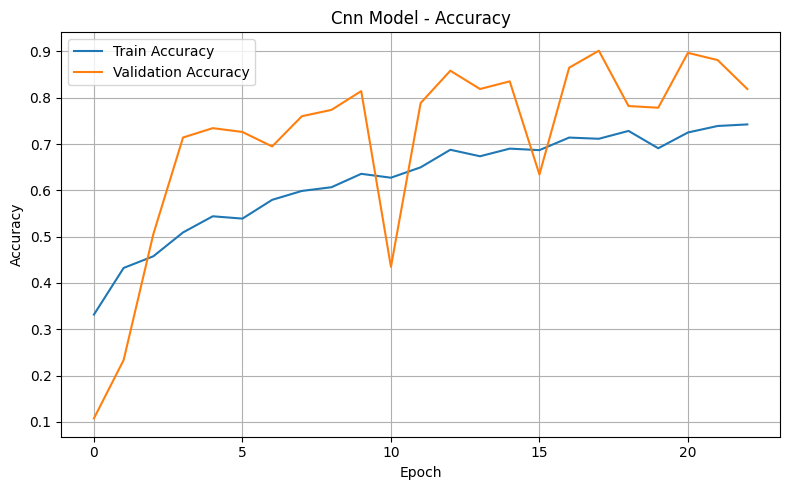

In [32]:
plot_accuracy(cnn_history, "Cnn Model")

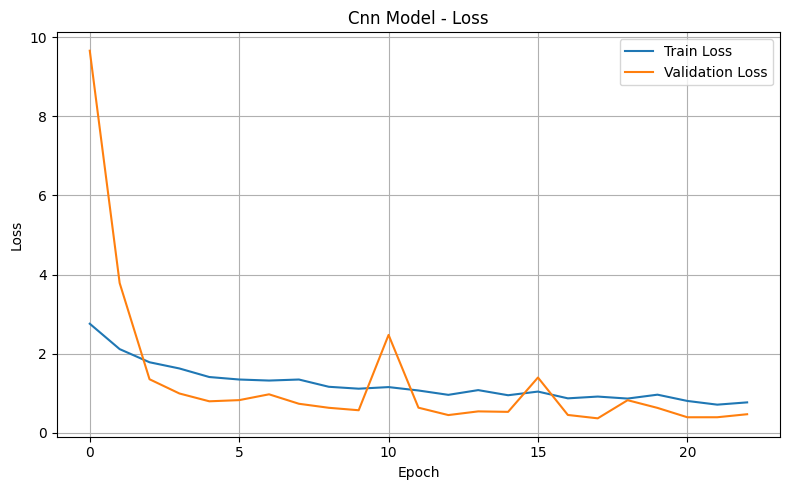

In [33]:
plot_loss(cnn_history,"Cnn Model")

In [34]:
# Replace paths with your actual history file paths
try:
    vgg16_history=load_history('models/vgg16_training_history.pkl')
except Exception as e:
    print(f"cannot load due to {e}")   

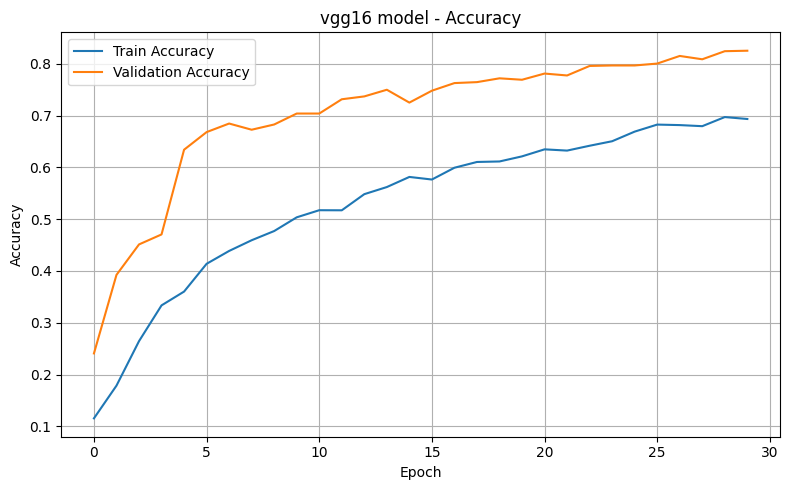

In [35]:
plot_accuracy(vgg16_history, "vgg16 model")

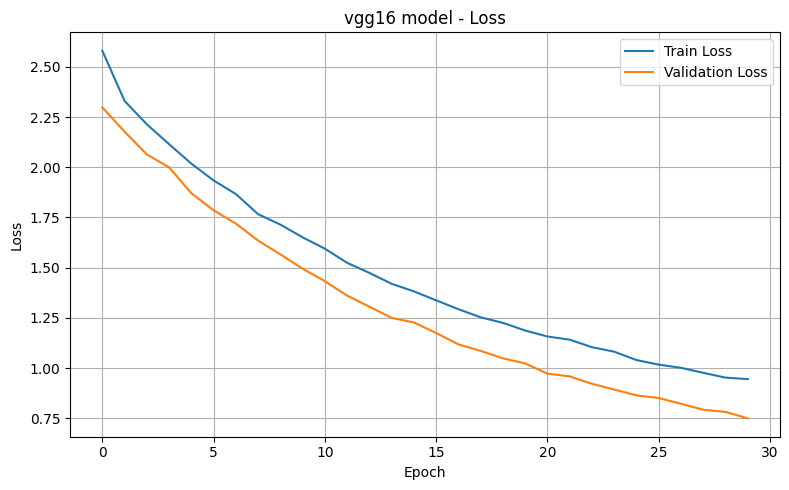

In [36]:
plot_loss(vgg16_history,"vgg16 model")

In [38]:
try:
    resnet_history=load_history('models/resnet50_training_history.pkl')
except Exception as e:
    print(f"cannot load due to {e}")  

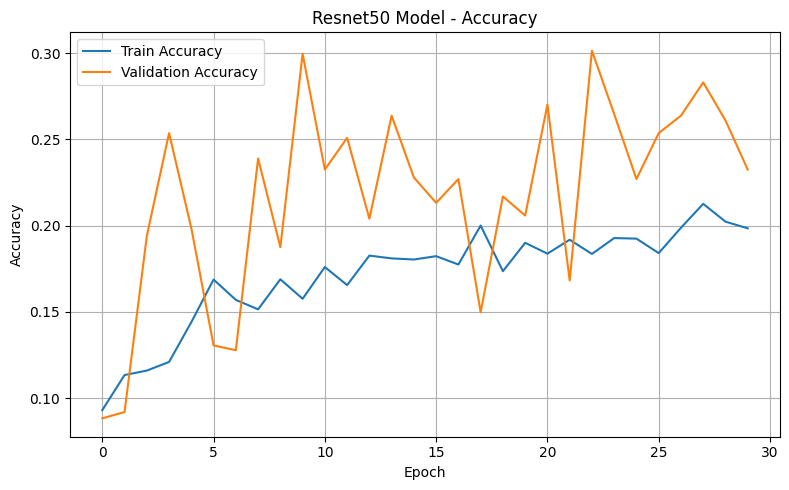

In [39]:
plot_accuracy(resnet_history,"Resnet50 Model")

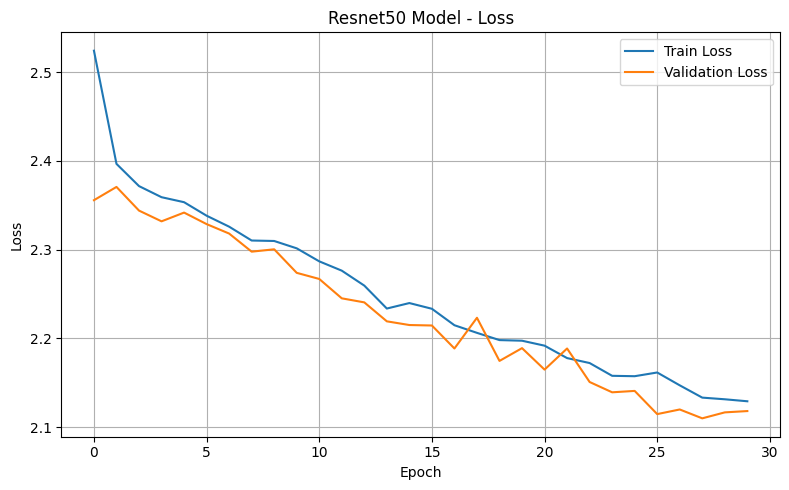

In [40]:
plot_loss(resnet_history,"Resnet50 Model")

In [41]:
try:
    mob_history=load_history('models/mobilenet_training_history.pkl')
except Exception as e:
    print(f"cannot load due to {e}")

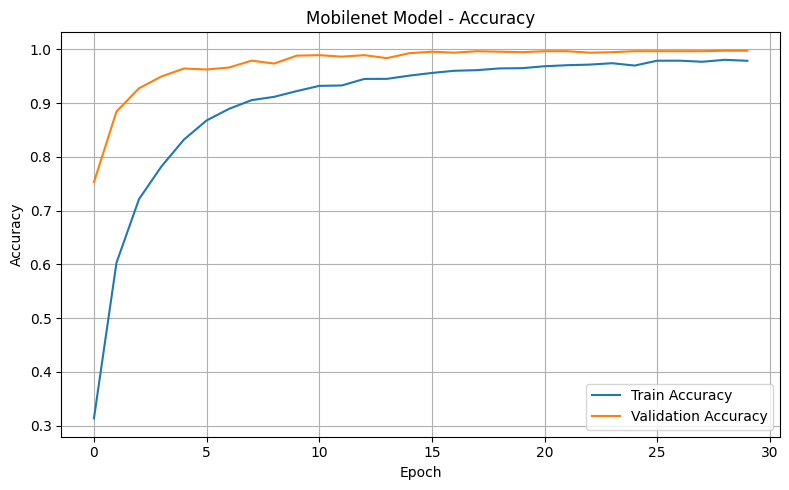

In [42]:
plot_accuracy(mob_history,"Mobilenet Model")

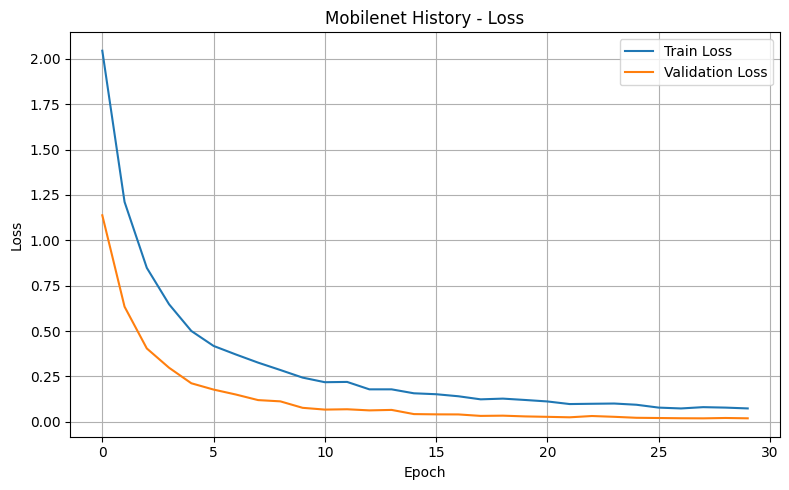

In [43]:
plot_loss(mob_history,"Mobilenet History")

In [44]:
try:
    inc_history=load_history('models/inceptionv3_training_history.pkl')
except Exception as e:
    print(f"cannot load due to {e}")

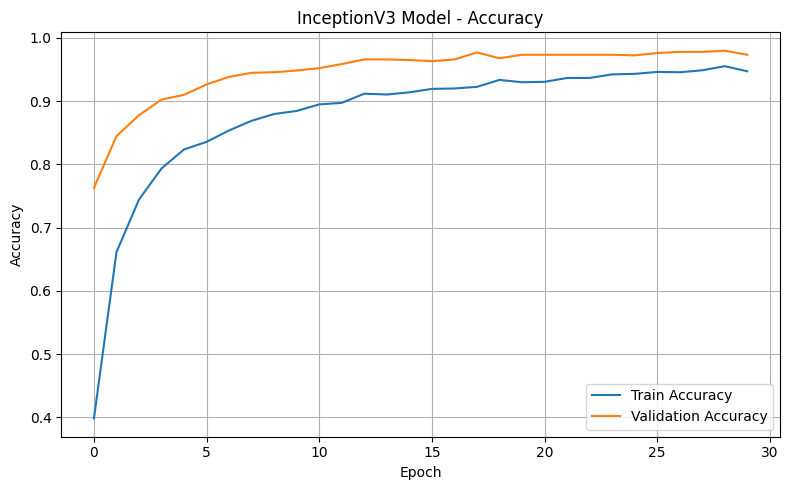

In [45]:
plot_accuracy(inc_history,"InceptionV3 Model")

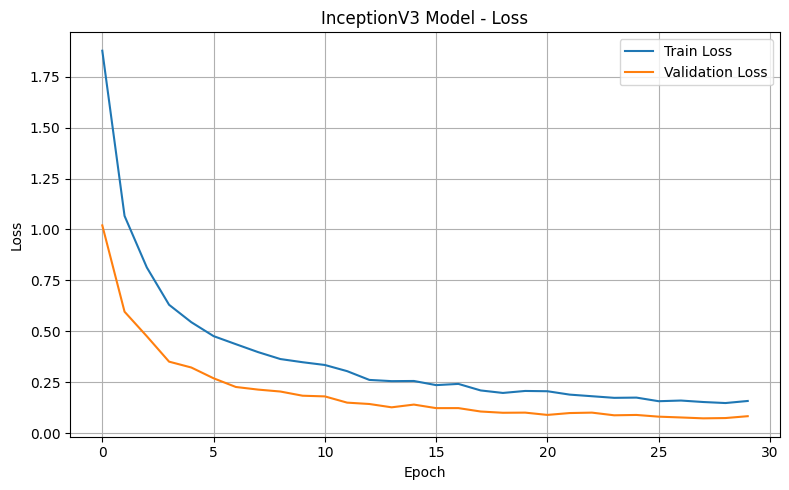

In [46]:
plot_loss(inc_history,"InceptionV3 Model")

In [47]:
try:
    efb0_history=load_history('models/efficientnetb0_training_history.pkl')
except Exception as e:
    print(f"cannot load due to {e}")

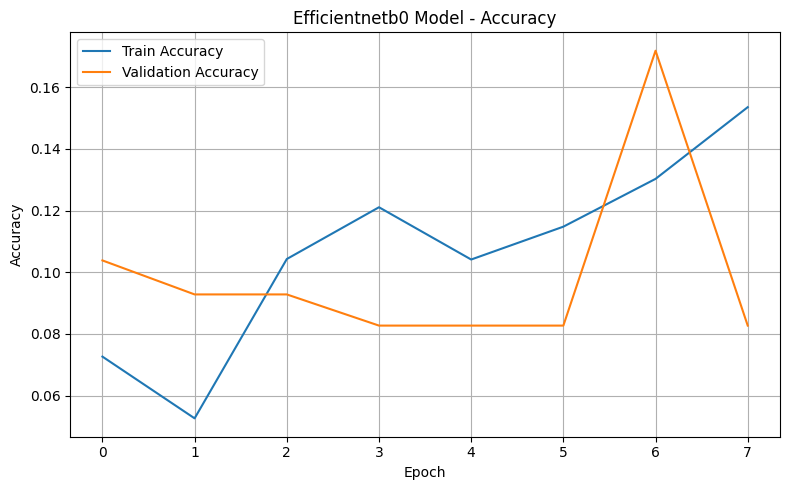

In [49]:
plot_accuracy(efb0_history,"Efficientnetb0 Model")

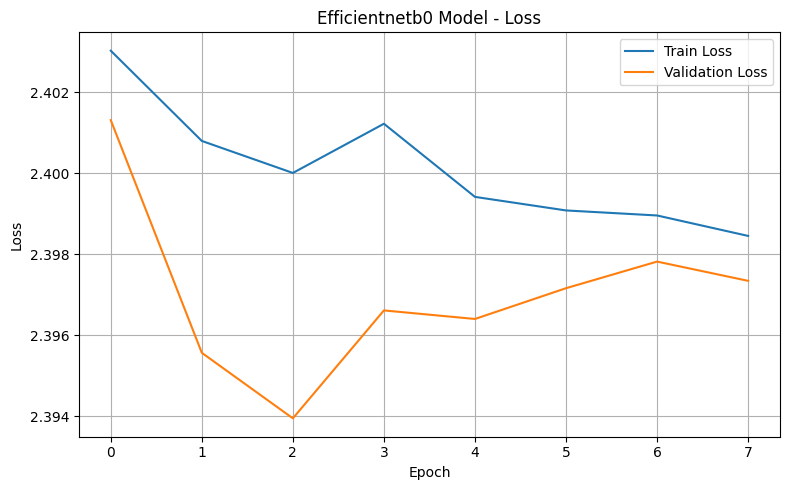

In [50]:
plot_loss(efb0_history,"Efficientnetb0 Model")

### Metrics such as accuracy, precision, recall, F1-score, and confusion matrix across all models.

Funtion for evaluation

In [22]:
def evaluate_model_all_in_one(model_or_path, test_generator, model_name):
    """
    Evaluates a model, prints classification report, plots confusion matrix,
    and shows average precision, recall, F1-score.
    
    Parameters:
    - model_or_path: Either a Keras model object or path to a saved model
    - test_generator: A Keras ImageDataGenerator (with shuffle=False)
    - model_name: Name of the model for display
    """
    from tensorflow.keras.models import load_model

    # 1️⃣ Load model only if a string path is given
    if isinstance(model_or_path, str):
        model = load_model(model_or_path)
    else:
        model = model_or_path  # Already loaded model

    # 2️⃣ Predict class probabilities
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # 3️⃣ Classification Report
    print(f"\n📊 Classification Report for {model_name}:\n")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # 4️⃣ Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels,
                annot_kws={"size": 12})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.show()

    # 5️⃣ Average metrics
    report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)
    avg_precision = report['macro avg']['precision']
    avg_recall = report['macro avg']['recall']
    avg_f1 = report['macro avg']['f1-score']

    print(f"\n🔍 Average Metrics for {model_name}:")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall:    {avg_recall:.4f}")
    print(f"F1-score:  {avg_f1:.4f}")


### CNN Model

100/100 [==============================] - 8s 78ms/step

📊 Classification Report for CNN model:

                                  precision    recall  f1-score   support

                     animal fish       0.98      0.91      0.94       520
                animal fish bass       0.09      0.31      0.14        13
   fish sea_food black_sea_sprat       0.86      0.98      0.92       298
   fish sea_food gilt_head_bream       0.84      0.74      0.78       305
   fish sea_food hourse_mackerel       0.97      0.88      0.93       286
        fish sea_food red_mullet       0.98      1.00      0.99       291
     fish sea_food red_sea_bream       0.77      0.92      0.84       273
          fish sea_food sea_bass       0.76      0.85      0.80       327
            fish sea_food shrimp       1.00      0.98      0.99       289
fish sea_food striped_red_mullet       0.97      0.87      0.92       293
             fish sea_food trout       0.97      0.87      0.92       292

             

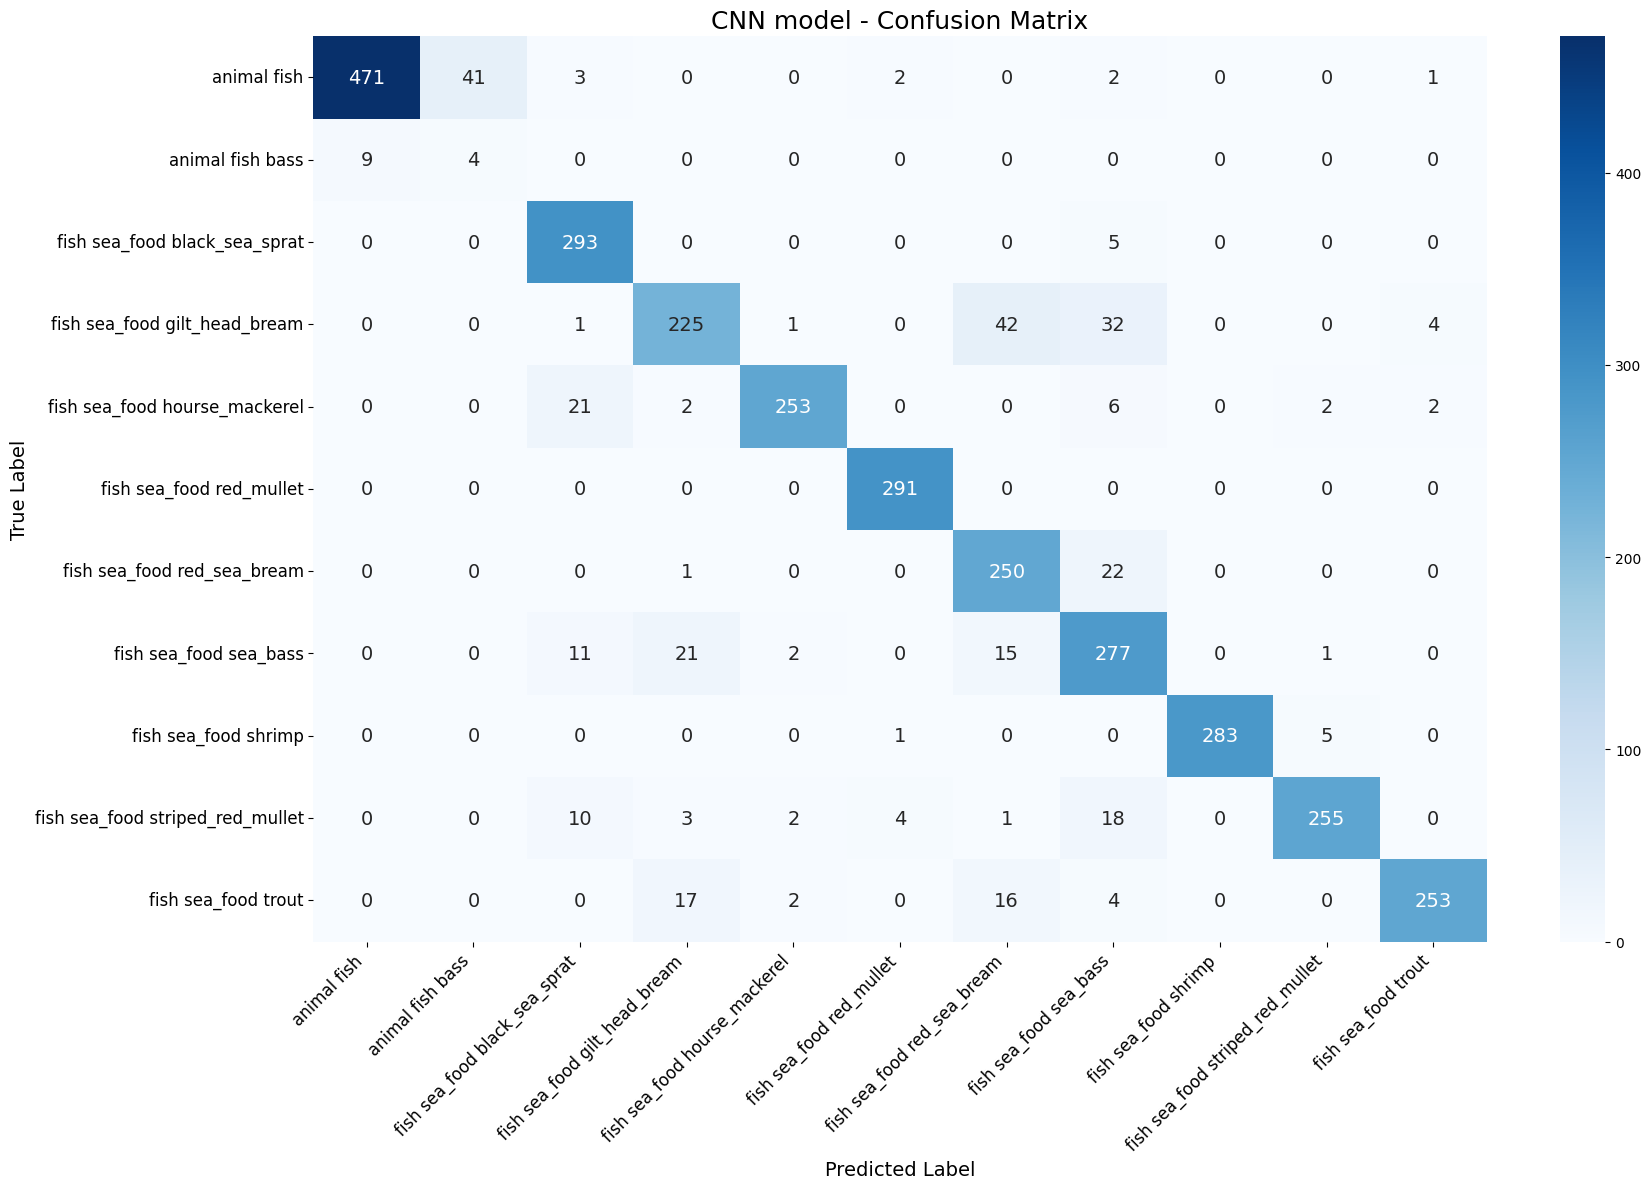

{'Model': 'CNN model',
 'Accuracy': 0.8958267963602133,
 'Precision': 0.8355961910906659,
 'Recall': 0.8452575738471885,
 'F1-Score': 0.832643892990781}

In [13]:
evaluate_model_all_in_one("models/cnn_best_model.h5",test_generator,"CNN model")

### VGG16 model

100/100 [==============================] - 38s 335ms/step

📊 Classification Report for VGG16 Model:

                                  precision    recall  f1-score   support

                     animal fish       0.99      0.96      0.98       520
                animal fish bass       0.35      0.62      0.44        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       0.99      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      0.99      0.99       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       0.99      1.00      0.99       289
fish sea_food striped_red_mullet       0.98      0.99      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

         

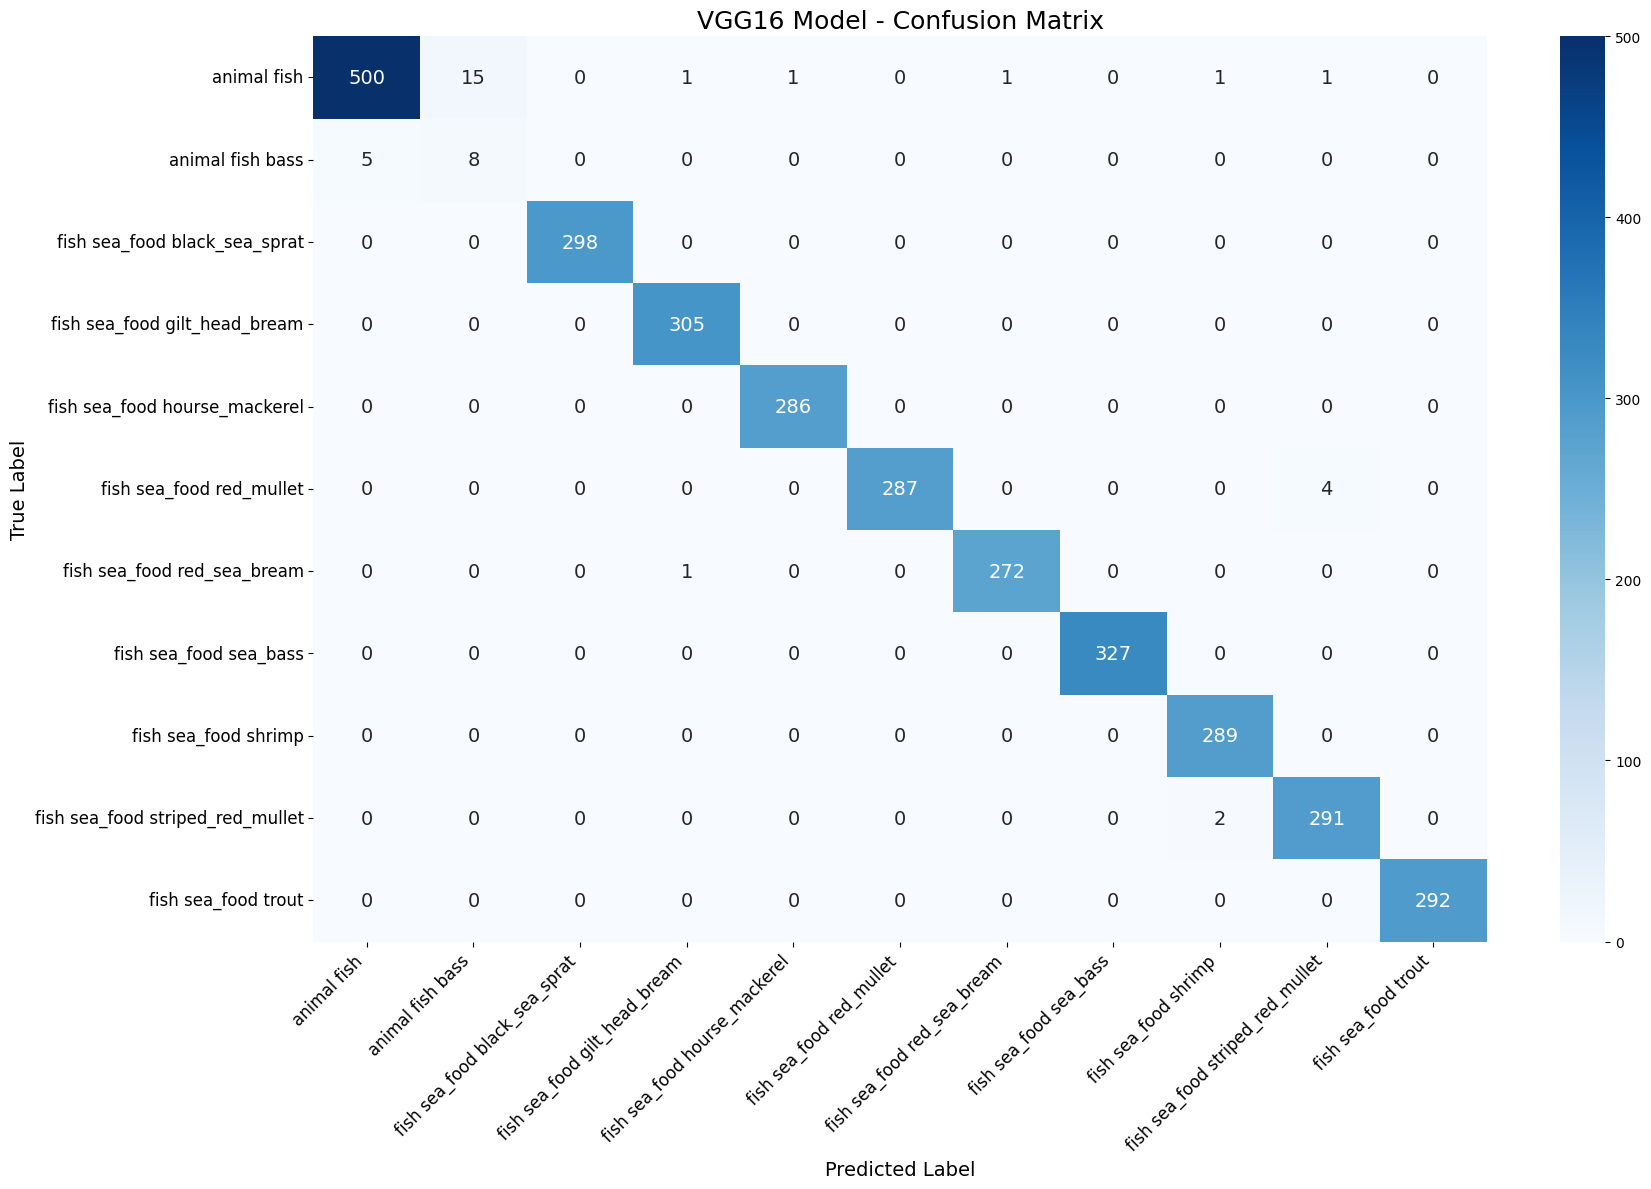

{'Model': 'VGG16 Model',
 'Accuracy': 0.9899592092877314,
 'Precision': 0.9360997500147209,
 'Recall': 0.9593353118387423,
 'F1-Score': 0.9443099587115729}

In [14]:
evaluate_model_all_in_one("models/vgg16_best_model.h5",test_generator,"VGG16 Model")

###  ResNet50 Model Evaluatio

100/100 [==============================] - 20s 171ms/step

📊 Classification Report for ResnNet50 Model:

                                  precision    recall  f1-score   support

                     animal fish       0.73      0.15      0.24       520
                animal fish bass       0.03      0.46      0.05        13
   fish sea_food black_sea_sprat       0.44      0.07      0.12       298
   fish sea_food gilt_head_bream       0.15      0.01      0.01       305
   fish sea_food hourse_mackerel       0.31      0.49      0.38       286
        fish sea_food red_mullet       0.26      0.37      0.31       291
     fish sea_food red_sea_bream       0.27      0.38      0.32       273
          fish sea_food sea_bass       0.31      0.25      0.28       327
            fish sea_food shrimp       0.31      0.43      0.36       289
fish sea_food striped_red_mullet       0.28      0.27      0.27       293
             fish sea_food trout       0.33      0.68      0.45       292

     

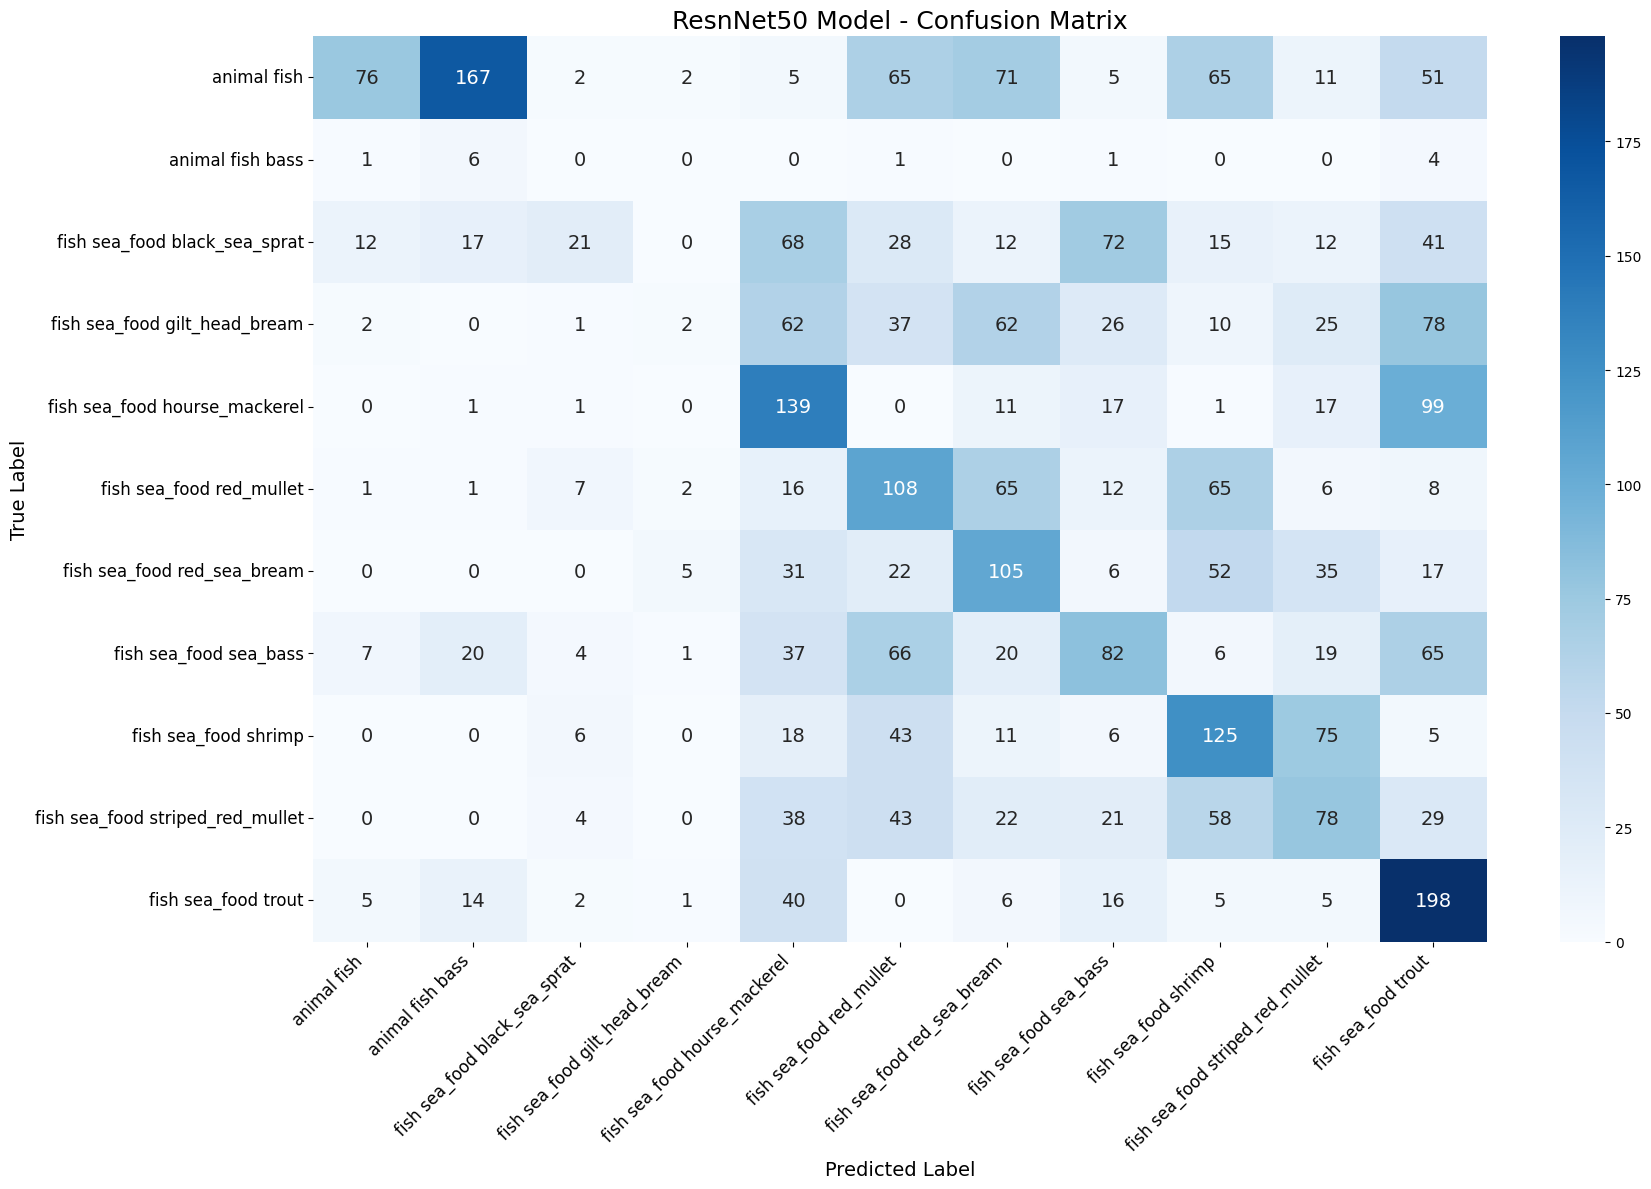

{'Model': 'ResnNet50 Model',
 'Accuracy': 0.2949482271728899,
 'Precision': 0.31081843268034026,
 'Recall': 0.3230970134613178,
 'F1-Score': 0.253270904481576}

In [15]:
evaluate_model_all_in_one("models/resnet50_best_model.h5",test_generator,"ResnNet50 Model")

### MobileNet Model evaluation

100/100 [==============================] - 10s 83ms/step

📊 Classification Report for MobileNet Model:

                                  precision    recall  f1-score   support

                     animal fish       1.00      0.98      0.99       520
                animal fish bass       0.71      0.92      0.80        13
   fish sea_food black_sea_sprat       0.99      1.00      0.99       298
   fish sea_food gilt_head_bream       0.99      1.00      1.00       305
   fish sea_food hourse_mackerel       0.99      1.00      0.99       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       0.99      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      0.99      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

      

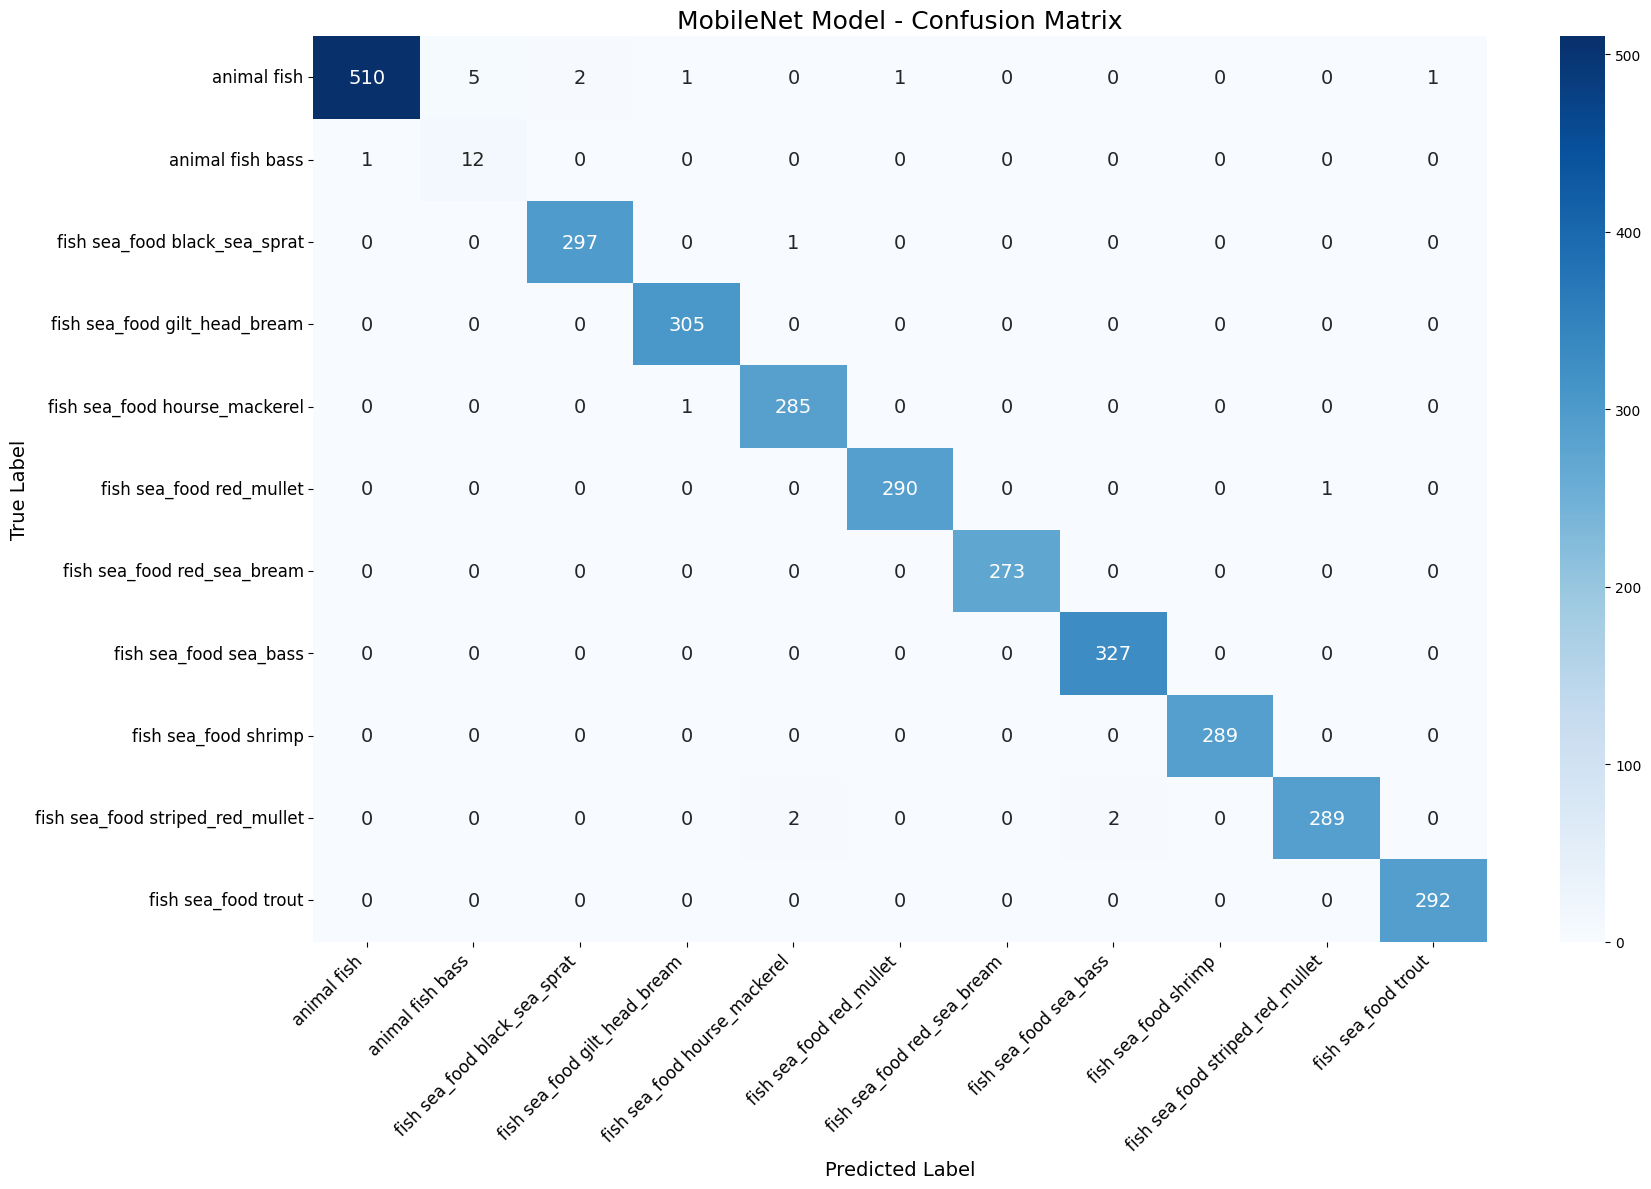

{'Model': 'MobileNet Model',
 'Accuracy': 0.9943520552243489,
 'Precision': 0.9694480381184651,
 'Recall': 0.9890823311274292,
 'F1-Score': 0.9779361880548453}

In [16]:
evaluate_model_all_in_one("models/mobilenet_best_model.h5",test_generator,"MobileNet Model")

### InceptionV3 model evaluation

100/100 [==============================] - 17s 133ms/step

📊 Classification Report for InceptionV3 Model:

                                  precision    recall  f1-score   support

                     animal fish       1.00      0.98      0.99       520
                animal fish bass       0.67      0.92      0.77        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       0.99      1.00      0.99       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      0.98      0.99       293
             fish sea_food trout       1.00      1.00      1.00       292

   

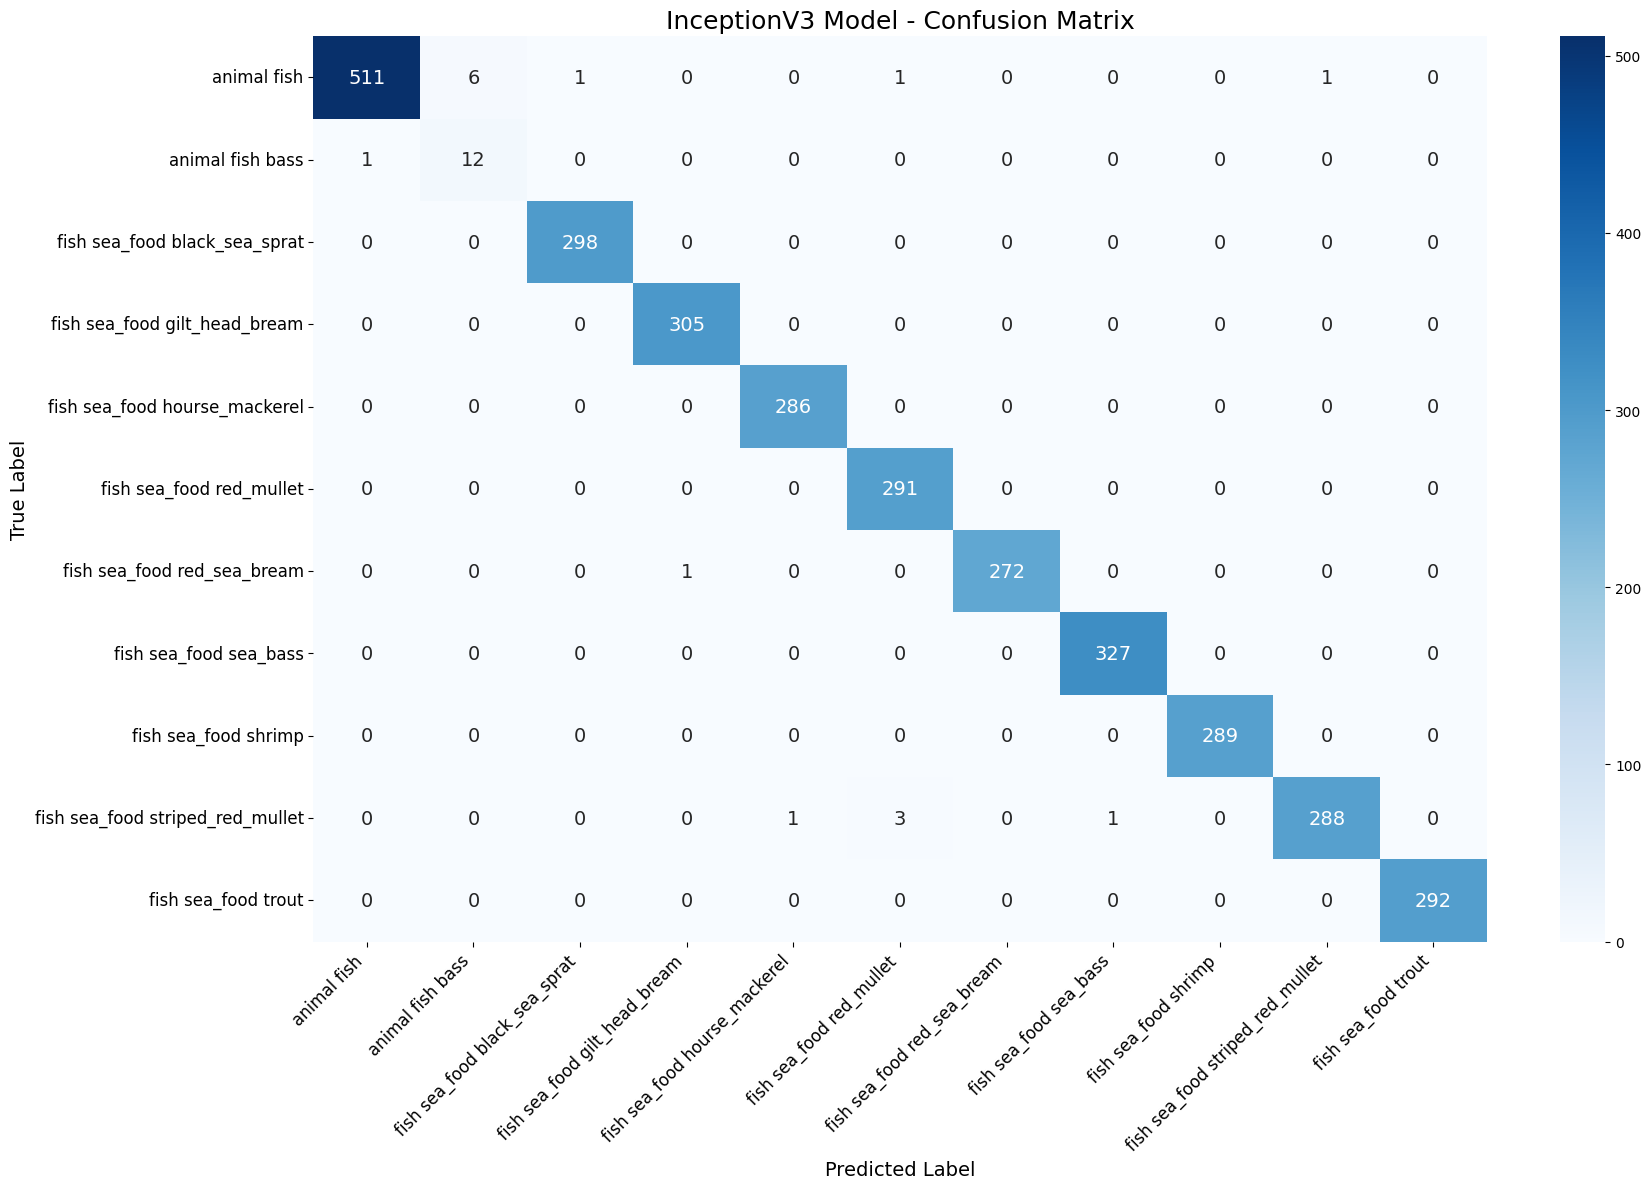

{'Model': 'InceptionV3 Model',
 'Accuracy': 0.9949796046438657,
 'Precision': 0.966777132319405,
 'Recall': 0.9895492164263495,
 'F1-Score': 0.9762681750237799}

In [17]:
evaluate_model_all_in_one("models/inceptionv3_best_model.h5",test_generator,"InceptionV3 Model")

### EfficientNetB0 model evaluation

100/100 [==============================] - 11s 105ms/step

📊 Classification Report for EfficientNetB0 Model:

                                  precision    recall  f1-score   support

                     animal fish       0.00      0.00      0.00       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.00      0.00      0.00       286
        fish sea_food red_mullet       0.09      1.00      0.17       291
     fish sea_food red_sea_bream       0.00      0.00      0.00       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.00      0.00      0.00       289
fish sea_food striped_red_mullet       0.00      0.00      0.00       293
             fish sea_food trout       0.00      0.00      0.00       292



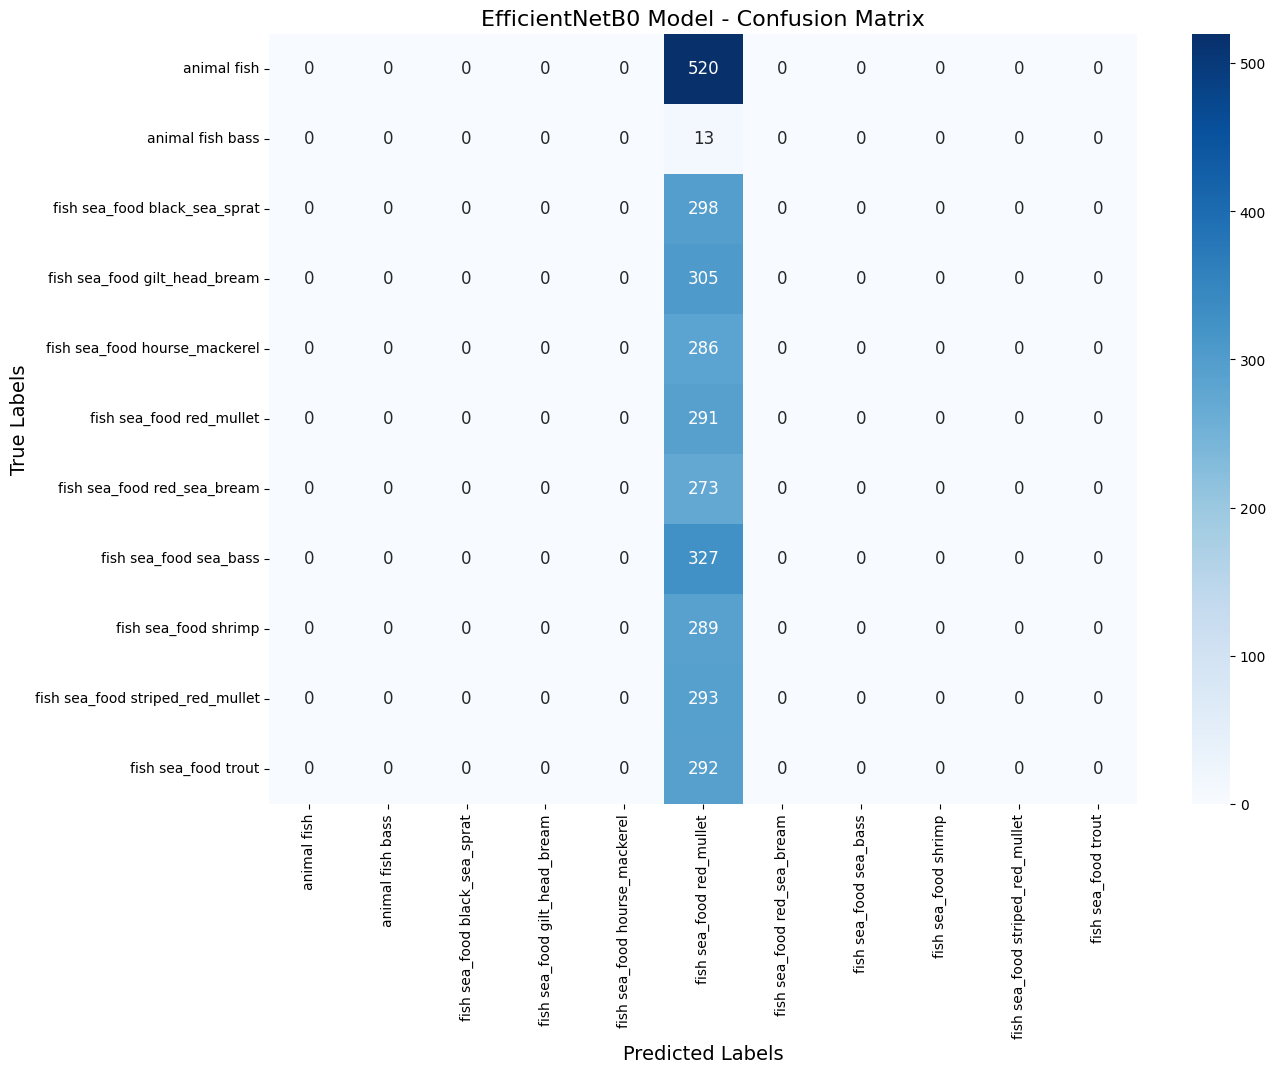


🔍 Average Metrics for EfficientNetB0 Model:
Precision: 0.0083
Recall:    0.0909
F1-score:  0.0152


In [28]:
evaluate_model_all_in_one(efficientnet_model,test_generator,"EfficientNetB0 Model")

# **Conclusion**

## 📌 Conclusion & Model Selection

After experimenting with **five different architectures** — Custom CNN, ResNet50, MobileNet, InceptionV3, and EfficientNetB0 — we compared their performance based on **validation accuracy** and **overall model suitability** for deployment.

| Model                | Final Validation Accuracy | Remarks |
|----------------------|---------------------------|---------|
| **MobileNet**        | **0.9972**                 | **Best performer** — Extremely lightweight, very fast inference, and excellent accuracy. Ideal for web deployment. |
| InceptionV3 (Fine-tuned) | 0.9926                  |  Very high accuracy, slightly heavier than MobileNet but still deployable. |
| CNN (Custom)         | 0.8254                     |  Moderate performance, not as good as pre-trained models. |
| ResNet50             | 0.3014                     |  Poor performance — discarded. |
| EfficientNetB0       | 0.0892                     |  Extremely poor performance in current setup — discarded. |
| VGG 16               | 0.9945                           | Heavier and slower than Mobilenet model.             |
### 🔍 Observations
- **MobileNet** consistently delivered the highest validation accuracy while keeping the model size small — critical for deployment in a **Streamlit web app** where quick loading and fast predictions are important.
- **InceptionV3 (fine-tuned)** also performed very well but is larger in size, which could slow down inference slightly in resource-constrained environments.
- **Custom CNN** performed reasonably but lacked the accuracy of transfer learning models.
- **ResNet50** and **EfficientNetB0** underperformed significantly in this dataset and are not recommended for use.

### 🏆 Final Choice
For the **Streamlit app**, **MobileNet** is selected as the primary deployment model due to:
- **Top accuracy** (99.72%)
- **Lightweight architecture** → faster loading
- **Lower computational requirements** → suitable for CPU-based inference
- **Ease of deployment** with `.h5` or `.SavedModel` format

InceptionV3 will be kept as a **secondary option** for comparison purposes.

---
